<a href="https://colab.research.google.com/github/dohyeon-kim012/MachineLearning-DeepLearning/blob/main/DeepLearning/21.RNN_LSTM_Attention%20Mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention 신경망 구현 및 학습

## Seq2Seq로 챗봇 만들기 ( with Attention )

In [1]:
!pip install konlpy

In [2]:
import random
import tensorflow as tf
from konlpy.tag import Okt

### 하이퍼 파라미터

In [3]:
num_epochs = 200
vocab_size = 2000

### Encoder 정의

In [25]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.emb = tf.keras.layers.Embedding(vocab_size, 64)
        self.lstm = tf.keras.layers.LSTM(512, return_sequences=True, return_state=True)
        # return_sequences = True 로 변경 -> 이를 K, V로 사용해야 함

    def call(self, x, training=False):
        x = self.emb(x)
        H, h, c = self.lstm(x) # 매 시퀀스마다의 Hidden State - 'H' 를 K, V로 사용해야 함
        
        return H, h, c

### Decoder 정의

1. Attention 매커니즘 추가  
    LSTM 출력에 Attention Value를 concat해서 dense 쪽으로 넘겨주는 것  
    -> **Attention Mechanism**  
    ```python
    self.att = tf.keras.layers.Attention()
    ```

2. 디코더에는 총 4개의 입력이 필요함
    - 디코더의 hidden state - `S` 
    - 인코더의 hidden state - `H`
    - 각 셀의 cell state - `Key, Value`
    - 이전 time step의 shifted Output

    ```python
x, s0, c0, H = inputs
# x : shifted Output
# s0 : t-1 번째 Decoder의 Hidden State
# c0 : t-1 번째 Decoder의 Cell State
# H : Encoder의 Hidden States -> K, V 로 활용됨
```

3. Attention으로 넘어가는 State를 따로 편집해야 함  

  --> 이전 스텝의 모든 내용을 이어서 Query ( S_ ) 로 만들기
    1. `s0[:, tf.newaxis, :]` : 1개의 time step ( tf.newaxis ) 를 추가해야 함
        - `S : (32, 64, 512)` 
            - `Training=True`면 64개의 x가 순서대로 들어가서 TimeStep이 쌓이니까..
            - `Training=False`면 쌓여가는 Sequence 별로 쌓이게 된다. (32, 1, 512) - (32, 2, 512) - (32, 3, 512)
        - 따라서 `Training=False` 일 때를 위해 time step용 axis를 추가
    2. `S[:, :-1, :]` : 마지막 hidden state의 출력은 내지 않는다 -> `<eos>`가 들어가야 하기 때문에  
        `axis=1` : newaxis와 :-1(63개) 가 합쳐져야 하기 때문에
    ```python
    S_ = tf.concat([s0[:, tf.newaxis, :], S[:, :-1, :]], axis=1)
    ```
    3. Attention Value 만들기  
        - Query ( S_ ) 를 먼저 입력하고, Key와 Value ( H ) 를 입력해주기  
        - A : 각 스텝 마다의 Attention Value ( 32, 64, 512 )
    ```python
        A = self.att([S_, H])
        ```
    4. Concat 의 결과인 벡터 V 만들기  
        - Dense로 넣어 주기 전에 Dense로 들어가게 될 Hidden State ( S ) 와 Attention Value ( A ) 르 concat하기
        - 스칼라값이 늘어날 수 있도록 ( 한 줄로 쭉 이어지도록 ) 가장 마지막 차원의 axis 추가
    ```python
        V = tf.concat([S, A], axis=-1)
        ```


64번의 반복 -> 512개의 결과

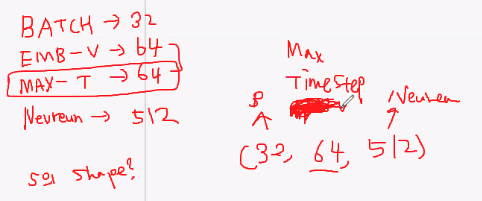

In [46]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()

        self.emb = tf.keras.layers.Embedding(vocab_size, 64)
        self.lstm = tf.keras.layers.LSTM(512, return_sequences=True, return_state=True)

        self.att = tf.keras.layers.Attention()

        self.dense = tf.keras.layers.Dense(vocab_size, activation='softmax')

    def call(self, inputs, training=False):
        x, s0, c0, H = inputs

        x = self.emb(x) 

        S, h, c = self.lstm(x, initial_state=[s0, c0]) # initial_state 변경

        S_ = tf.concat([s0[:, tf.newaxis, :], S[:, :-1, :]], axis=1)

        A = self.att([S_, H])
        V = tf.concat([S, A], axis=-1)

        y = self.dense(V)

        return y, h, c

### Seq2Seq ( 메인 모델 ) 정의


In [47]:
class Seq2Seq(tf.keras.Model):
    def __init__(self, sos, eos): 
        super(Seq2Seq, self).__init__()
        self.sos = sos 
        self.eos = eos 
        
        self.enc = Encoder()
        self.dec = Decoder()

    def call(self, inputs, training=False):
        if training:
            x, y = inputs 
            H, h, c = self.enc(x) 

            # Key, Value로 사용되어지는 hidden_state를 디코더에 넣어줌
            y, _, __ = self.dec((y, h, c, H)) 

            return y 
        
        else: 
            x = inputs # x : 질문 문장
            H, h, c = self.enc(x) # 전체 Hidden States(H) 리턴

            y = tf.convert_to_tensor(self.sos)
            y = tf.reshape(y, (1, 1)) 

            seq = tf.TensorArray(tf.int32, 64) 

            for idx in tf.range(64):
                y, h, c = self.dec([y, h, c, H]) # 마지막에 H (Key, Value) 넘겨주기 
                y = tf.cast(tf.argmax(y, axis=-1), dtype=tf.int32)

                y = tf.reshape(y, (1, 1)) 

                seq = seq.write(idx, y) 

                if y == self.eos:
                    break
            
            return tf.reshape(seq.stack(), (1, 64))

## 학습, 테스트 루프 정의


In [48]:
@tf.function
def train_step(model, inputs, labels, loss_object, optimizer, train_loss, train_accuracy):
    output_labels = labels[:, 1:] # 출력값
    shifted_labels = labels[:, :-1] # 입력값

    with tf.GradientTape() as tape:
        predictions = model([inputs, shifted_labels], training=True) # 예측을 하고
        loss = loss_object(output_labels, predictions) # 정답이 이거였어~ 라고 이야기하기

    # 기울기 계산
    gradients = tape.gradient(loss, model.trainable_variables)
    # 오차역전파 - weight 업데이트
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # loss와 accuracy 업데이트
    train_loss(loss)
    train_accuracy(output_labels, predictions)

@tf.function
def test_step(model, inputs):
    # 입력값만 주고 결과 확인을 위해 추론값 return받기
    return model(inputs, training=False)

## 데이터셋 준비 
`chatbot_data.csv` ( http://www.aihub.or.kr )

In [49]:
from konlpy.tag import Okt

dataset_file = 'chatbot_data.csv'
okt = Okt()

In [50]:
with open(dataset_file, 'r') as file:
    lines = file.readlines()
    seq = [" ".join(okt.morphs(line)) for line in lines] # 한 줄씩 형태소 분석 후, 다시 한 줄로 합쳐주기

In [51]:
seq[:6]

['아이스 아메리카노 하나요 \n',
 '테이크아웃 하실 건가 요 ? \n',
 '저 카푸치노 로 주문 할게요 \n',
 '시럽 은 얼마나 뿌려 드릴 까요 ? \n',
 '저 도장 다 모았는데 나중 에 써도 되나요 ? \n',
 '네 다음 에 써도 됩니다 \n']

In [52]:
questions = seq[::2]
answers = ['\t ' + lines for lines in seq[1::2]]
# \t : <sos> , 대답 앞 쪽에 붙여서 대답을 분류해내는 수단으로 쓸 것

print(questions[:3])
print(answers[:3])

['아이스 아메리카노 하나요 \n', '저 카푸치노 로 주문 할게요 \n', '저 도장 다 모았는데 나중 에 써도 되나요 ? \n']
['\t 테이크아웃 하실 건가 요 ? \n', '\t 시럽 은 얼마나 뿌려 드릴 까요 ? \n', '\t 네 다음 에 써도 됩니다 \n']


- `\t` : `<sos>`  
- `\n` : `<eos>`

### 데이터 잘라내기

In [53]:
num_samples = len(questions) # 500개
term = list(range(num_samples))
print("before shuffle : {}".format(term[:10]))

# 랜덤 시드 고정
random.seed(0)
random.shuffle(term)
print("after shuffle : {}".format(term[:10]))

before shuffle : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
after shuffle : [419, 459, 130, 431, 370, 26, 201, 56, 366, 108]


In [54]:
train_q = [] # X_train
train_a = [] # y_train

test_q = [] # X_test
test_a = [] # y_test

In [55]:
test_ratio = 0.2 
test_cnt = int(len(questions) * test_ratio)

train_indices = term[test_cnt:]
test_indices = term[:test_cnt]

for idx in train_indices:
    train_q.append(questions[idx])
    train_a.append(answers[idx])

for idx in test_indices:
    test_q.append(questions[idx])
    test_a.append(answers[idx])

```python
for idx, qna in enumerate(zip(questions, answers)):
    q, a = qna
    
    if term[idx] > num_samples // 5 : 
```

In [56]:
test_q[:3], test_a[:3]

(['사이 즈 업 해서 주세요 \n',
  '캐러멜 드리블 이랑 통 잡아 칩이요 \n',
  '시즌 메뉴 와 함께 구성 되어 있는 세트 메뉴 가 있나요 ? \n'],
 ['\t 네 결제 는 어떻게 도 와 드릴 까요 ? \n',
  '\t 6700원 결제 도 와 드리겠습니다 \n',
  '\t 네 치즈 케이크 와 시즌 메뉴 두 잔 으로 구성 된 세트 메뉴 있습니다 \n'])

### 토크나이징

In [57]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~')

In [58]:
tokenizer.fit_on_texts(train_q + train_a) 
print(tokenizer.word_index)

{'\n': 1, '\t': 2, '네': 3, '주세요': 4, '로': 5, '아메리카노': 6, '는': 7, '에': 8, '아이스': 9, '도': 10, '요': 11, '잔': 12, '이': 13, '한': 14, '드릴': 15, '까요': 16, '은': 17, '입니다': 18, '사이즈': 19, '가': 20, '있나요': 21, '결제': 22, '수': 23, '하나': 24, '있습니다': 25, '와': 26, '드시고': 27, '해주세요': 28, '할게요': 29, '으로': 30, '라테': 31, '추가': 32, '따뜻한': 33, '주문': 34, '사용': 35, '음료': 36, '되나요': 37, '여기': 38, '아니요': 39, '거': 40, '얼마': 41, '개': 42, '그럼': 43, '카드': 44, '랑': 45, '드리겠습니다': 46, '케이크': 47, '어떤': 48, '걸': 49, '포인트': 50, '가시나요': 51, '한잔': 52, '할인': 53, '적립': 54, '다': 55, '커피': 56, '더': 57, '인가요': 58, '쿠폰': 59, '가요': 60, '드릴게요': 61, '티': 62, '건': 63, '가능합니다': 64, '알겠습니다': 65, '에서': 66, '가능한가요': 67, '매장': 68, '를': 69, '진동': 70, '면': 71, '벨': 72, '안': 73, '번호': 74, '만': 75, '에요': 76, '메뉴': 77, '하나요': 78, '디카': 79, '페인': 80, '건가': 81, '샷': 82, '있어요': 83, '됩니다': 84, '테이크아웃': 85, '예요': 86, '스무디': 87, '게': 88, '카페라테': 89, '두': 90, '같이': 91, '자몽': 92, '하고': 93, '치즈케이크': 94, '제일': 95, '뭐': 96, '카페모카': 97, '기프티콘': 98, '세트':

#### 정수 인코딩

In [59]:
train_q_seq = tokenizer.texts_to_sequences(train_q)
train_a_seq = tokenizer.texts_to_sequences(train_a)

test_q_seq  = tokenizer.texts_to_sequences(test_q)
test_a_seq  = tokenizer.texts_to_sequences(test_a)

In [60]:
train_q_seq[:3], train_a_seq[:3]

([[85, 12, 30, 4, 1], [3, 239, 1], [3, 300, 301, 47, 4, 1]],
 [[2, 627, 628, 629, 73, 66, 630, 631, 35, 113, 23, 378, 1],
  [2, 57, 162, 63, 139, 60, 1],
  [2, 36, 7, 227, 5, 15, 16, 1]])

#### 패딩 후 최종 데이터 정리

In [61]:
X_train = pad_sequences(
    train_q_seq,
    value=0,
    padding='pre',
    maxlen=64 
)

y_train = pad_sequences(
    train_a_seq,
    value=0,
    padding='post',
    maxlen=65
)

X_test = pad_sequences( test_q_seq, value=0, padding='pre', maxlen=64 )
y_test = pad_sequences( test_a_seq, value=0, padding='post', maxlen=65 )

In [62]:
X_train[0], y_train[0]

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, 85, 12, 30,  4,  1], dtype=int32),
 array([  2, 627, 628, 629,  73,  66, 630, 631,  35, 113,  23, 378,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       dtype=int32))

In [63]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1024).batch(32).prefetch(1024)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1).prefetch(1024)

## 학습 환경 정의

모델 생성, 손실 함수, 최적화 알고리즘, 평가지표 정의

In [64]:
model = Seq2Seq(
    sos=tokenizer.word_index['\t'],
    eos=tokenizer.word_index['\n']
)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

## 학습 루프 동작

In [65]:
EPOCHS = 200
for epoch in range(EPOCHS):
    for seqs, labels in train_ds:
        train_step(model, seqs, labels, loss_object, optimizer, train_loss, train_accuracy)

    print("Epoch : {}, Loss : {:.3f}, Accuracy : {:.3f}".format(epoch+1,train_loss.result(),train_accuracy.result()*100))

    train_loss.reset_states()
    train_accuracy.reset_states()

Epoch : 1, Loss : 2.886, Accuracy : 83.074
Epoch : 2, Loss : 0.625, Accuracy : 90.625
Epoch : 3, Loss : 0.571, Accuracy : 90.875
Epoch : 4, Loss : 0.558, Accuracy : 91.168
Epoch : 5, Loss : 0.547, Accuracy : 91.113
Epoch : 6, Loss : 0.539, Accuracy : 91.137
Epoch : 7, Loss : 0.532, Accuracy : 91.113
Epoch : 8, Loss : 0.519, Accuracy : 91.199
Epoch : 9, Loss : 0.511, Accuracy : 91.215
Epoch : 10, Loss : 0.505, Accuracy : 91.242
Epoch : 11, Loss : 0.491, Accuracy : 91.414
Epoch : 12, Loss : 0.471, Accuracy : 91.625
Epoch : 13, Loss : 0.461, Accuracy : 91.883
Epoch : 14, Loss : 0.457, Accuracy : 92.219
Epoch : 15, Loss : 0.445, Accuracy : 92.250
Epoch : 16, Loss : 0.440, Accuracy : 92.383
Epoch : 17, Loss : 0.428, Accuracy : 92.488
Epoch : 18, Loss : 0.421, Accuracy : 92.523
Epoch : 19, Loss : 0.420, Accuracy : 92.598
Epoch : 20, Loss : 0.408, Accuracy : 92.629
Epoch : 21, Loss : 0.396, Accuracy : 92.664
Epoch : 22, Loss : 0.406, Accuracy : 92.727
Epoch : 23, Loss : 0.397, Accuracy : 92.7

## 테스트 루프 만들기

In [66]:
for test_seq, test_labels in test_ds:
  prediction = test_step(model, test_seq)
  
  test_q = tokenizer.sequences_to_texts(test_seq.numpy()) # 질문
  test_a = tokenizer.sequences_to_texts(test_labels.numpy()) # 실제 대답
  test_p = tokenizer.sequences_to_texts(prediction.numpy()) # 챗봇의 대답

  print("______")
  print("질문 : \t{}".format(test_q))
  print("실제 대답 : {}".format(test_a))
  print("챗봇 대답 : {}".format(test_p))

______
질문 : 	['사이 즈 업 해서 주세요 \n']
실제 대답 : ['\t 네 결제 는 어떻게 도 와 드릴 까요 \n']
챗봇 대답 : ['네 시럽 넣어 드릴 까요 \n']
______
질문 : 	['캐러멜 드리블 이랑 통 잡아 \n']
실제 대답 : ['\t 결제 도 와 드리겠습니다 \n']
챗봇 대답 : ['플레인 원두 딸기스무디 를 뭘 로 하시겠어요 \n']
______
질문 : 	['시즌 메뉴 와 함께 되어 있는 세트 메뉴 가 있나요 \n']
실제 대답 : ['\t 네 치즈 케이크 와 시즌 메뉴 두 잔 으로 세트 메뉴 있습니다 \n']
챗봇 대답 : ['티 와 입니다 \n']
______
질문 : 	['아메리카노 1 잔 주세요 \n']
실제 대답 : ['\t 매장 에서 드시고 가시나요 \n']
챗봇 대답 : ['드시고 가시나요 \n']
______
질문 : 	['그럼 와 아이스 아메리카노 로 할게요 \n']
실제 대답 : ['\t 더 필요하신 건 없나요 \n']
챗봇 대답 : ['네 총 아이스 벨 로 드릴 까요 \n']
______
질문 : 	['밀크 티 있나요 \n']
실제 대답 : ['\t 네 있습니다 \n']
챗봇 대답 : ['네 가능합니다 \n']
______
질문 : 	['네 기프티콘 여기 있어요 \n']
실제 대답 : ['\t 아메리카노 기프티콘 사용 되었습니다 \n']
챗봇 대답 : ['네 카페라테 해드리겠습니다 \n']
______
질문 : 	['네 오늘 의 커피 로 주세요 \n']
실제 대답 : ['\t 네 사이즈 는 어떤 걸 로 주문 넣어 드릴 까요 \n']
챗봇 대답 : ['카페모카 말씀 카페모카 입니다 \n']
______
질문 : 	['포인트 사용 없이 적립 만 할게요 \n']
실제 대답 : ['\t 네 멤버십 카드 주시 면 도 와 드리겠습니다 \n']
챗봇 대답 : ['네 그럼 바로 결제 도 와 드리겠습니다 \n']
______
질문 : 	['네 감사합니다 \n']
실제 대답 : ['\t 따뜻한 카페라테 한 잔 \n']